In [1]:
import os
import math
from datetime import datetime, timedelta

import matplotlib as mpl
from matplotlib import pyplot, gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter
from matplotlib.patches import Rectangle

from metpy import plots, calc, interpolate
from metpy.units import units

import numpy as np

import pyart

import profile_io as io

from scipy.ndimage import gaussian_filter1d


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [34]:
def inverse_dist_weight(dist, field, roi):
    field[field==-9999] = np.nan
    filt = np.logical_and(~np.isnan(field), dist<=roi)
    local_values = field[filt]
    local_weights = 1-(dist[filt]/roi)
    total_weight = np.sum(local_weights)

    if len(local_values) == 0:
        return np.nan
    return np.sum(local_values*local_weights)/total_weight

In [3]:
#config for dataset
dataset1_config = {'cut_down_s':315,'sondeid':'9931','timestamp':'2023-07-24_1631'}
dataset2_config = {'cut_down_s':255,'sondeid':'9935','timestamp':'2023-07-24_1636'}

#read dataset 1
timestamp1 = dataset1_config['timestamp']
sonde_id1 = dataset1_config['sondeid']
filename1 = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp1}_{sonde_id1}.raw_flight_history.csv'
profile1, metadata1 = io.decode_raw_flight_history_nosplit(filename1, remove_nan_rows=True)

#read dataset 2
timestamp2 = dataset2_config['timestamp']
sonde_id2 = dataset2_config['sondeid']
filename2 = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp2}_{sonde_id2}.raw_flight_history.csv'
profile2, metadata2 = io.decode_raw_flight_history_nosplit(filename2, remove_nan_rows=True)

profile1_cutdown_idx = np.argmin(np.abs(dataset1_config['cut_down_s'] - profile1['time']))
profile2_cutdown_idx = np.argmin(np.abs(dataset2_config['cut_down_s'] - profile2['time']))

In [47]:
#match radar data
radar_site_alt = 810 #m 
bottom_pressure = 900
top_pressure = 400
radar_id = 2
gmt_offset = -6
output_image_path = '/g/data/kl02/jss548/hail-research/hailsonde/nhp_output'
roi = 3000 #m
skip = 10
#get location and time
snd_lat = profile1['lat'][0]
snd_lon = profile1['lon'][0]
profile1_start_dt = datetime.strptime(os.path.basename(filename1)[0:15], '%Y-%m-%d_%H%M') - timedelta(hours = gmt_offset) #MUST BE UTC+0 TIME
profile2_start_dt = datetime.strptime(os.path.basename(filename2)[0:15], '%Y-%m-%d_%H%M') - timedelta(hours = gmt_offset) #MUST BE UTC+0 TIME

#init profile for radar matching
array_length = len(profile1['hght'])
alt_refl_profile1 = profile1['hght']._magnitude[::skip] + radar_site_alt
pres_refl_profile1 = profile1['pres']._magnitude[::skip]
lat_refl_profile1 = profile1['lat'][::skip]
lon_refl_profile1 = profile1['lon'][::skip]
time_refl_profile1 = profile1['time'][::skip]
radar_refl_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_zdr_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_kdp_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)
radar_rhv_profile1 = np.zeros_like(alt_refl_profile1, dtype=float)

array_length = len(profile2['hght'])
alt_refl_profile2 = profile2['hght']._magnitude[::skip] + radar_site_alt
pres_refl_profile2 = profile2['pres']._magnitude[::skip]
lat_refl_profile2 = profile2['lat'][::skip]
lon_refl_profile2 = profile2['lon'][::skip]
time_refl_profile2 = profile2['time'][::skip]
radar_refl_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_zdr_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_kdp_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)
radar_rhv_profile2 = np.zeros_like(alt_refl_profile2, dtype=float)

#load radar data
# radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset'
# radars, file_dt_list, mid_point_dt_list = io.load_nhp_radar_data(radar_vols_path, 360)

radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset_phido'
radars, file_dt_list, mid_point_dt_list = io.load_nhp_phido_radar_data(radar_vols_path, 360)


In [48]:
#match profile1 to radar data
for i in range(len(alt_refl_profile1)):
    print(i, 'of', len(alt_refl_profile1))
    profile1_target_dt = profile1_start_dt + timedelta(seconds = time_refl_profile1[i])
    profile1_radar_idx = io.find_nearest_dt_idx(profile1_target_dt, file_dt_list)
    
    gate_lon = np.ravel(radars[profile1_radar_idx].gate_longitude['data'])
    gate_lat = np.ravel(radars[profile1_radar_idx].gate_latitude['data'])
    gate_alt = np.ravel(radars[profile1_radar_idx].gate_altitude['data'] + radar_site_alt)
    gate_refl = np.ravel(radars[profile1_radar_idx].fields['DBZH']['data'].data)
    gate_zdr = np.ravel(radars[profile1_radar_idx].fields['ZDR']['data'].data)
    gate_kdp = np.ravel(radars[profile1_radar_idx].fields['KDP']['data'].data)
    gate_rhv = np.ravel(radars[profile1_radar_idx].fields['RHOHV']['data'].data)

    dist = np.ravel(np.sqrt((io.degrees2meters(gate_lat - lat_refl_profile1[i]))**2 + (io.degrees2meters(gate_lon - lon_refl_profile1[i]))**2 + (gate_alt - alt_refl_profile1[i])**2))

    radar_refl_profile1[i] = inverse_dist_weight(dist, gate_refl, roi)
    radar_zdr_profile1[i] = inverse_dist_weight(dist, gate_zdr, roi)
    radar_kdp_profile1[i] = inverse_dist_weight(dist, gate_kdp, roi)
    radar_rhv_profile1[i] = inverse_dist_weight(dist, gate_rhv, roi)

#match profile2 to radar data
for i in range(len(alt_refl_profile2)):
    print(i, 'of', len(alt_refl_profile2))
    profile2_target_dt = profile2_start_dt + timedelta(seconds = time_refl_profile2[i])
    profile2_radar_idx = io.find_nearest_dt_idx(profile2_target_dt, file_dt_list)
    
    gate_lon = np.ravel(radars[profile2_radar_idx].gate_longitude['data'])
    gate_lat = np.ravel(radars[profile2_radar_idx].gate_latitude['data'])
    gate_alt = np.ravel(radars[profile2_radar_idx].gate_altitude['data'] + radar_site_alt)
    gate_refl = np.ravel(radars[profile2_radar_idx].fields['DBZH']['data'].data)
    gate_zdr = np.ravel(radars[profile2_radar_idx].fields['ZDR']['data'].data)
    gate_kdp = np.ravel(radars[profile2_radar_idx].fields['KDP']['data'].data)
    gate_rhv = np.ravel(radars[profile2_radar_idx].fields['RHOHV']['data'].data)

    dist = np.ravel(np.sqrt((io.degrees2meters(gate_lat - lat_refl_profile2[i]))**2 + (io.degrees2meters(gate_lon - lon_refl_profile2[i]))**2 + (gate_alt - alt_refl_profile2[i])**2))
    radar_refl_profile2[i] = inverse_dist_weight(dist, gate_refl, roi)
    radar_zdr_profile2[i] = inverse_dist_weight(dist, gate_zdr, roi)
    radar_kdp_profile2[i] = inverse_dist_weight(dist, gate_kdp, roi)
    radar_rhv_profile2[i] = inverse_dist_weight(dist, gate_rhv, roi)

0 of 27
1 of 27
2 of 27
3 of 27
4 of 27
5 of 27
6 of 27
7 of 27
8 of 27
9 of 27
10 of 27
11 of 27
12 of 27
13 of 27
14 of 27
15 of 27
16 of 27
17 of 27
18 of 27
19 of 27
20 of 27
21 of 27
22 of 27
23 of 27
24 of 27
25 of 27
26 of 27
0 of 23
1 of 23
2 of 23
3 of 23
4 of 23
5 of 23
6 of 23
7 of 23
8 of 23
9 of 23
10 of 23
11 of 23
12 of 23
13 of 23
14 of 23
15 of 23
16 of 23
17 of 23
18 of 23
19 of 23
20 of 23
21 of 23
22 of 23


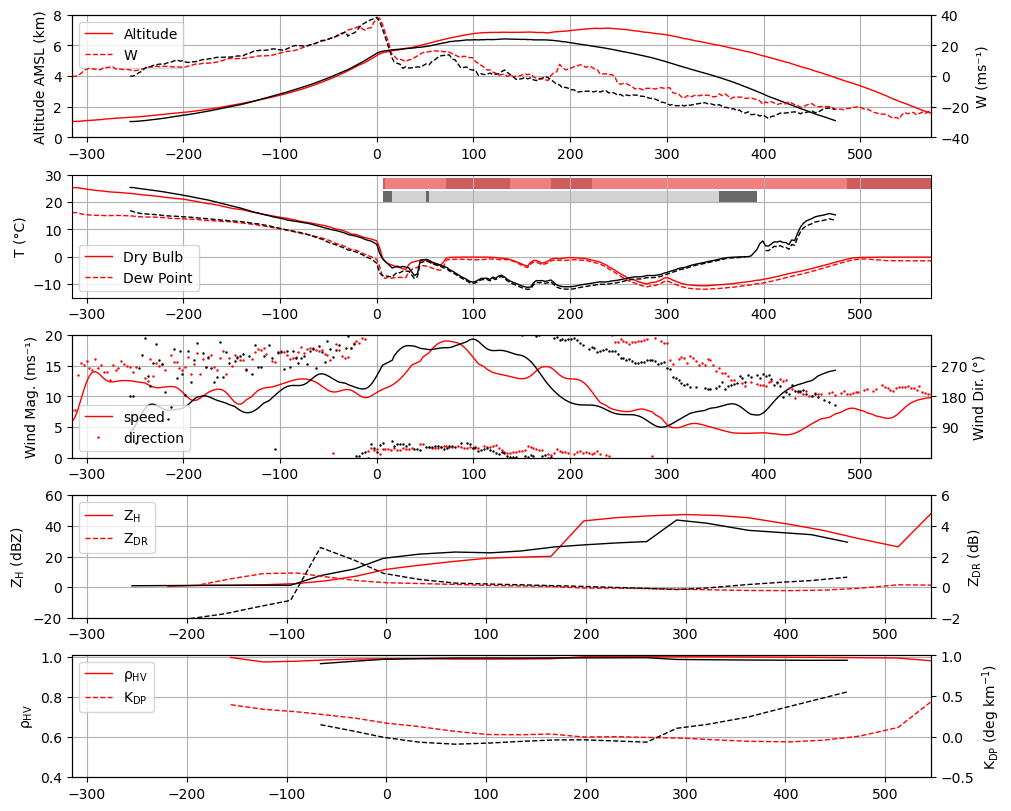

In [52]:
pyplot.rcParams.update({'mathtext.default':  'regular' })

fig = pyplot.figure(constrained_layout = True, figsize = (10, 8))
#fig.suptitle(f'hailsonde 9931 and 9935')

profile1_time_offset = profile1['time'] - profile1['time'][profile1_cutdown_idx]
profile2_time_offset = profile2['time'] - profile2['time'][profile2_cutdown_idx]
time_refl_profile1_offset = time_refl_profile1 - profile1['time'][profile1_cutdown_idx]
time_refl_profile2_offset = time_refl_profile2 - profile2['time'][profile2_cutdown_idx]


ax = pyplot.subplot(511)
ax.plot(profile1_time_offset,profile1['hght']/1000, 'r-', linewidth=1, label='Altitude')
ax.plot(profile2_time_offset,profile2['hght']/1000, 'k-', linewidth=1, label='_nolegend_')
ax.set_ylabel('Altitude AMSL (km)')
ax.set_ylim([0,8])
ax.set_xlim([np.min(profile1_time_offset),np.max(profile1_time_offset)])
ax2 = ax.twinx()
ax2.plot(profile1_time_offset, profile1['rise'], 'r--', linewidth=1, label='W')
ax2.plot(profile2_time_offset, profile2['rise'], 'k--', linewidth=1, label='_nolegend_')
ax2.set_ylabel('W (ms⁻¹)')
ax2.set_ylim([-40,40])
ax2.set_xlim([np.min(profile1_time_offset),np.max(profile1_time_offset)])
ax.grid()
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=2)

ax = pyplot.subplot(512)
ax.plot(profile1_time_offset, profile1['tmpc'], 'r-', linewidth=1, label='Dry Bulb')
ax.plot(profile1_time_offset, profile1['dwpc'], 'r--', linewidth=1, label='Dew Point')
ax.plot(profile2_time_offset, profile2['tmpc'], 'k-', linewidth=1, label='_nolegend_')
ax.plot(profile2_time_offset, profile2['dwpc'], 'k--', linewidth=1, label='_nolegend_')
ax.set_yticks([-10,0,10,20,30])
ax.set_ylabel('T (°C)')
ax.set_ylim([-15,30])
ax.set_xlim([np.min(profile1_time_offset), np.max(profile1_time_offset)])
ax.grid()
ax.legend(loc=0)

#determine growth modes profile 1
profile1_growth_type = np.zeros_like(profile1_time_offset)
profile1_growth_type[np.array(profile1['tmpc'])<0.1] = 1 #wet
profile1_growth_type[np.array(profile1['tmpc'])<-1] = 2 #dry
last_value = 0
start_i = 0
for i in range(len(profile1_growth_type)):
    new_value = profile1_growth_type[i]
    if new_value == last_value and i < len(profile1_growth_type)-1:
        # no change
        continue
    else:
        #plot
        rec_x = profile1_time_offset[start_i]
        rec_width = profile1_time_offset[i] - profile1_time_offset[start_i]
        if last_value == 0:
            pass
        elif last_value == 1:
            ax.add_patch(Rectangle((rec_x, 25), rec_width, 4, facecolor="indianred"))
        else:
            ax.add_patch(Rectangle((rec_x, 25), rec_width, 4, facecolor="lightcoral"))
        #reset
        start_i = i
    last_value = new_value

#determine growth modes
profile2_growth_type = np.zeros_like(profile2_time_offset)
profile2_growth_type[np.array(profile2['tmpc'])<=0.5] = 1 #wet
profile2_growth_type[np.array(profile2['tmpc'])<-1] = 2 #dry
last_value = 0
start_i = 0
for i in range(len(profile2_growth_type)):
    new_value = profile2_growth_type[i]
    if new_value == last_value and i < len(profile2_growth_type)-1:
        # no change
        continue
    else:
        #plot
        rec_x = profile2_time_offset[start_i]
        rec_width = profile2_time_offset[i] - profile2_time_offset[start_i]
        if last_value == 0:
            pass
        elif last_value == 1:
            ax.add_patch(Rectangle((rec_x, 20), rec_width, 4, facecolor="dimgrey"))
        else:
            ax.add_patch(Rectangle((rec_x, 20), rec_width, 4, facecolor="lightgrey"))
        #reset
        start_i = i
    last_value = new_value



#profile 1 growth

ax = pyplot.subplot(513)
ax.plot(profile1_time_offset, gaussian_filter1d(profile1['wspd'], 3), 'r-', linewidth=1, label='speed')
ax.plot(profile2_time_offset, gaussian_filter1d(profile2['wspd'], 3), 'k-', linewidth=1, label='_nolegend_')
ax.set_ylabel('Wind Mag. (ms⁻¹)')
ax.set_ylim([0,20])
ax.set_xlim([np.min(profile1_time_offset), np.max(profile1_time_offset)])
ax.set_yticks([0,5,10,15,20])
ax.grid()
ax2 = ax.twinx()
ax2.plot(profile1_time_offset, profile1['wdir']._magnitude, 'r.', label='direction', markersize=1.5)
ax2.plot(profile2_time_offset, profile2['wdir']._magnitude, 'k.', label='_nolegend_', markersize=1.5)
ax2.set_ylabel('Wind Dir. (°)')
ax2.set_ylim([0,360])
ax2.set_yticks([90,180,270])
ax.set_xlim([np.min(profile1_time_offset), np.max(profile1_time_offset)])
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=3)

#ideally add cressman reflectivity and zdr

ax = pyplot.subplot(514)
ax.plot(time_refl_profile1_offset, radar_refl_profile1, 'r-', linewidth=1, label='$Z_H$')
ax.plot(time_refl_profile2_offset, radar_refl_profile2, 'k-', linewidth=1, label='_nolegend_')
ax.set_ylabel('$Z_H$ (dBZ)')
ax.set_ylim([-20,60])
ax2 = ax.twinx()
ax2.plot(time_refl_profile1_offset, radar_zdr_profile1, 'r--', linewidth=1, label='$Z_{DR}$')
ax2.plot(time_refl_profile2_offset, radar_zdr_profile2, 'k--', linewidth=1, label='_nolegend_')
ax2.set_ylabel('$Z_{DR}$ (dB)')
ax2.set_ylim([-2,6])
ax.set_xlim([np.min(time_refl_profile1_offset), np.max(time_refl_profile1_offset)])
ax2.set_xlim([np.min(time_refl_profile1_offset), np.max(time_refl_profile1_offset)])
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=2)
ax.grid()

ax = pyplot.subplot(515)
ax.plot(time_refl_profile1_offset, radar_rhv_profile1, 'r-',linewidth=1, label='$ρ_{HV}$')
ax.plot(time_refl_profile2_offset, radar_rhv_profile2, 'k-',linewidth=1, label='_nolegend_')
ax.set_ylabel('$ρ_{HV}$')
ax.set_ylim([0.4,1.01])
ax2 = ax.twinx()
ax2.plot(time_refl_profile1_offset, radar_kdp_profile1, 'r--',linewidth=1, label='$K_{DP}$')
ax2.plot(time_refl_profile2_offset, radar_kdp_profile2, 'k--',linewidth=1, label='_nolegend_')
ax2.set_ylabel('$K_{DP}$ (deg km$^{-1}$)')
ax2.set_ylim([-0.5,1.01])
ax.set_xlim([np.min(time_refl_profile1_offset), np.max(time_refl_profile1_offset)])
ax2.set_xlim([np.min(time_refl_profile1_offset), np.max(time_refl_profile1_offset)])
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc=2)
ax.grid()

#overlay

pyplot.savefig(f'{output_image_path}/Publication_hailsonde_timeseries.png')